In [82]:
# !pip install pandas
# !pip install pyspark
# !pip install matplotlib
# !pip install seaborn

In [83]:
import warnings
warnings.filterwarnings("ignore")

In [84]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import pyspark
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("PySpark").getOrCreate()
# spark

In [85]:
from pyspark.sql import functions as F
from pyspark.sql.types import *

In [86]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler
from pyspark.ml.evaluation import ClusteringEvaluator

In [87]:
def printdf(df, l=5):
    return df.limit(l).toPandas()

def nullcount(df):
    return {col: df.filter(df[col].isNull()).count() for col in df.columns}

def shape(df):
    print((df.count(), len(df.columns)))

# Load data
**dataset from RFM with PySpark**

In [88]:
rfm_numbers = spark.read.csv("customer_rfm_numbers.csv", 
                             inferSchema=True, 
                             header=True)
printdf(rfm_numbers)

,CustomerID,Recency,Frequency,Monetary
0,15619,11,1,337.0
1,17389,1,34,31852.0
2,14450,181,3,485.0
3,15727,17,7,5220.0
4,15790,11,1,225.0


<!-- # Prepare data -->

# Inspect

In [89]:
df_rfm_numbers = rfm_numbers.toPandas()
df_rfm_numbers.describe()

,CustomerID,Recency,Frequency,Monetary
count,3921.000000,3921.000000,3921.000000,3921.000000
mean,15561.471563,92.722265,4.246111,1870.640653
std,1576.823683,99.528532,7.205750,7485.207270
min,12346.000000,1.000000,1.000000,0.000000
25%,14208.000000,18.000000,1.000000,301.000000
50%,15569.000000,51.000000,2.000000,654.000000
75%,16913.000000,143.000000,5.000000,1587.000000
max,18287.000000,374.000000,210.000000,259665.000000


<Axes: xlabel='Monetary', ylabel='Count'>

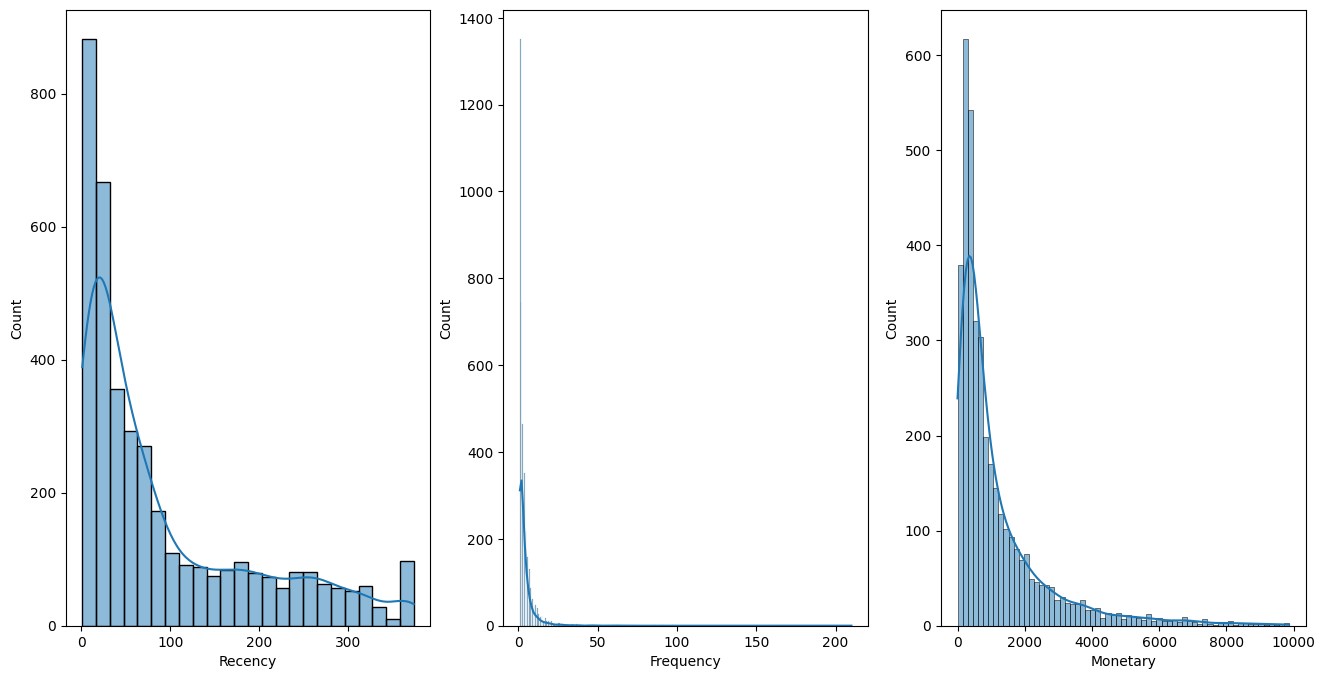

In [90]:
fig, ax = plt.subplots(1, 3, figsize=(16, 8))

# Recency distribution plot
sns.histplot(df_rfm_numbers['Recency'], kde=True, ax=ax[0])

# Frequency distribution plot
sns.histplot(df_rfm_numbers.query('Frequency < 1000')['Frequency'], kde=True, ax=ax[1])

# Monetary distribution plot
sns.histplot(df_rfm_numbers.query('Monetary < 10000')['Monetary'], kde=True, ax=ax[2])

# K-Means Clustering

In [91]:
# Since log transformation doesn't work with negative and zero values, lets get rid of negative and zeros

rfm_data = (
    rfm_numbers.withColumn(
        "Monetary", 
        F.when(F.col("Monetary") <= 0, 1)
         .otherwise(F.col("Monetary")))
)

# rfm_data = rfm_numbers
# printdf(rfm_data)

# Elbow Analysis

In [92]:
features = rfm_data.columns[1:]

printdf(rfm_data)

,CustomerID,Recency,Frequency,Monetary
0,15619,11,1,337.0
1,17389,1,34,31852.0
2,14450,181,3,485.0
3,15727,17,7,5220.0
4,15790,11,1,225.0


In [93]:
assembler = VectorAssembler(
    inputCols=features, 
    outputCol="rfm_features")

assembled_data = assembler.transform(rfm_data)

assembled_data = assembled_data.select('CustomerID', 'Recency', 'Frequency', 'Monetary' , 'rfm_features')

printdf(assembled_data)

,CustomerID,Recency,Frequency,Monetary,rfm_features
0,15619,11,1,337.0,"[11.0, 1.0, 337.0]"
1,17389,1,34,31852.0,"[1.0, 34.0, 31852.0]"
2,14450,181,3,485.0,"[181.0, 3.0, 485.0]"
3,15727,17,7,5220.0,"[17.0, 7.0, 5220.0]"
4,15790,11,1,225.0,"[11.0, 1.0, 225.0]"


In [94]:
scaler = StandardScaler(inputCol='rfm_features', outputCol='rfm_standardized')

data_scale = scaler.fit(assembled_data)

scaled_data = data_scale.transform(assembled_data)

printdf(scaled_data)

,CustomerID,Recency,Frequency,Monetary,rfm_features,rfm_standardized
0,15619,11,1,337.0,"[11.0, 1.0, 337.0]","[0.11052107132513378, 0.13877806001284734, 0.0..."
1,17389,1,34,31852.0,"[1.0, 34.0, 31852.0]","[0.010047370120466708, 4.71845404043681, 4.255..."
2,14450,181,3,485.0,"[181.0, 3.0, 485.0]","[1.818573991804474, 0.41633418003854206, 0.064..."
3,15727,17,7,5220.0,"[17.0, 7.0, 5220.0]","[0.17080529204793404, 0.9714464200899314, 0.69..."
4,15790,11,1,225.0,"[11.0, 1.0, 225.0]","[0.11052107132513378, 0.13877806001284734, 0.0..."


In [95]:
# working with `scaled_data`
for k in range(3, 10):
    k_means = KMeans(featuresCol='rfm_standardized', k=k)
    model = k_means.fit(scaled_data)
    predictions = model.transform(scaled_data)
    evaluator = ClusteringEvaluator(featuresCol='rfm_standardized')
    silhouette = evaluator.evaluate(predictions)
    print(k,silhouette)

3 0.7267096166996703
4 0.7699024192887607
5 0.7692184459646207
6 0.7750336922220649
7 0.6966136770635311
8 0.6973129306268208
9 0.691210856868582


# K = 4

In [96]:
k_means = KMeans(featuresCol='rfm_standardized', k=4)
model = k_means.fit(scaled_data)
predictions = model.transform(scaled_data)

In [97]:
printdf(predictions)

,CustomerID,Recency,Frequency,Monetary,rfm_features,rfm_standardized,prediction
0,15619,11,1,337.0,"[11.0, 1.0, 337.0]","[0.11052107132513378, 0.13877806001284734, 0.0...",1
1,17389,1,34,31852.0,"[1.0, 34.0, 31852.0]","[0.010047370120466708, 4.71845404043681, 4.255...",3
2,14450,181,3,485.0,"[181.0, 3.0, 485.0]","[1.818573991804474, 0.41633418003854206, 0.064...",0
3,15727,17,7,5220.0,"[17.0, 7.0, 5220.0]","[0.17080529204793404, 0.9714464200899314, 0.69...",1
4,15790,11,1,225.0,"[11.0, 1.0, 225.0]","[0.11052107132513378, 0.13877806001284734, 0.0...",1


In [98]:
predictions.createOrReplaceTempView("TMP")

sql_str = """
select prediction,
count(1) as total_count,
sum(Monetary) sum_monetary,
avg(Monetary) avg_monetary,
avg(Recency) as avg_recency,
avg(Frequency) as avg_frequency
from TMP
group by 1
"""

predict_stats = spark.sql(sql_str)
printdf(predict_stats)

,prediction,total_count,sum_monetary,avg_monetary,avg_recency,avg_frequency
0,1,2647,3029588.0,1144.536456,45.322629,3.327541
1,3,289,2236051.0,7737.200692,17.044983,17.169550
2,2,23,1645481.0,71542.652174,19.782609,59.956522
3,0,962,423663.0,440.398129,247.623701,1.559252


In [111]:
predict_stats.createOrReplaceTempView("PREDICT_STAS")

sql_str = """
select *,
total_count / sum(total_count) over () as customer_ratio,
sum_monetary / sum(sum_monetary) over () as monetary_ratio
from PREDICT_STAS
"""

cluster_stats = spark.sql(sql_str)
printdf(cluster_stats)

23/09/27 20:44:50 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/09/27 20:44:50 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/09/27 20:44:50 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/09/27 20:44:50 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/09/27 20:44:50 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/09/27 20:44:50 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/09/27 2

,prediction,total_count,sum_monetary,avg_monetary,avg_recency,avg_frequency,customer_ratio,monetary_ratio
0,1,2647,3029588.0,1144.536456,45.322629,3.327541,0.675083,0.413044
1,3,289,2236051.0,7737.200692,17.044983,17.169550,0.073706,0.304856
2,2,23,1645481.0,71542.652174,19.782609,59.956522,0.005866,0.224339
3,0,962,423663.0,440.398129,247.623701,1.559252,0.245346,0.057761


In [100]:
# Join other information with the prediction result-set

rfm_score = spark.read.csv('retail_loyalty_rfm.csv', 
                           inferSchema=True, 
                           header=True)
#rfm_score = rfm_score.select("CustomerID", "Recency", "Frequency", "Monetary", "RFM_Score", "RFM_ScoreGroup", "Loyalty")
rfm_score = rfm_score.select("CustomerID", "RFM_Score", "RFM_ScoreGroup", "Loyalty")
# printdf(rfm_score)

In [101]:
combined_result = predictions.join(rfm_score, on='CustomerID', how='inner')
printdf(combined_result)

,CustomerID,Recency,Frequency,Monetary,rfm_features,rfm_standardized,prediction,RFM_Score,RFM_ScoreGroup,Loyalty
0,15619,11,1,337.0,"[11.0, 1.0, 337.0]","[0.11052107132513378, 0.13877806001284734, 0.0...",1,7,133,Gold
1,17389,1,34,31852.0,"[1.0, 34.0, 31852.0]","[0.010047370120466708, 4.71845404043681, 4.255...",3,3,111,Platinum
2,14450,181,3,485.0,"[181.0, 3.0, 485.0]","[1.818573991804474, 0.41633418003854206, 0.064...",0,7,322,Gold
3,15727,17,7,5220.0,"[17.0, 7.0, 5220.0]","[0.17080529204793404, 0.9714464200899314, 0.69...",1,3,111,Platinum
4,15790,11,1,225.0,"[11.0, 1.0, 225.0]","[0.11052107132513378, 0.13877806001284734, 0.0...",1,6,123,Gold


In [102]:
combined_result_df = combined_result.toPandas()

combined_result_df.to_csv('combined_result_k4.csv', index=False)

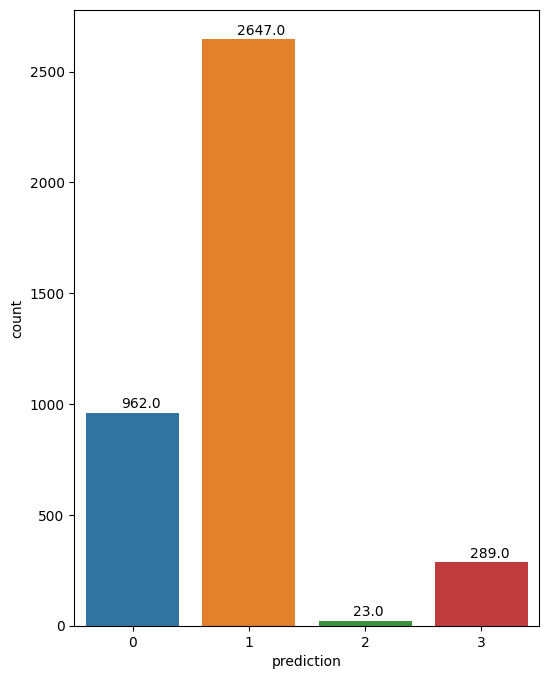

In [103]:
# inspect our loyalty segmentation

# combined_result_df = combined_result_df.sort_values("RFM_Score")

fig, ax = plt.subplots(1, 1, figsize=(6, 8))

sns.countplot(x="prediction", data=combined_result_df)
for p in ax.patches:
    ax.annotate('{}'.format(p.get_height()), (p.get_x() + 0.3, p.get_height() + 20))

# Observation

<Axes: xlabel='prediction', ylabel='Monetary'>

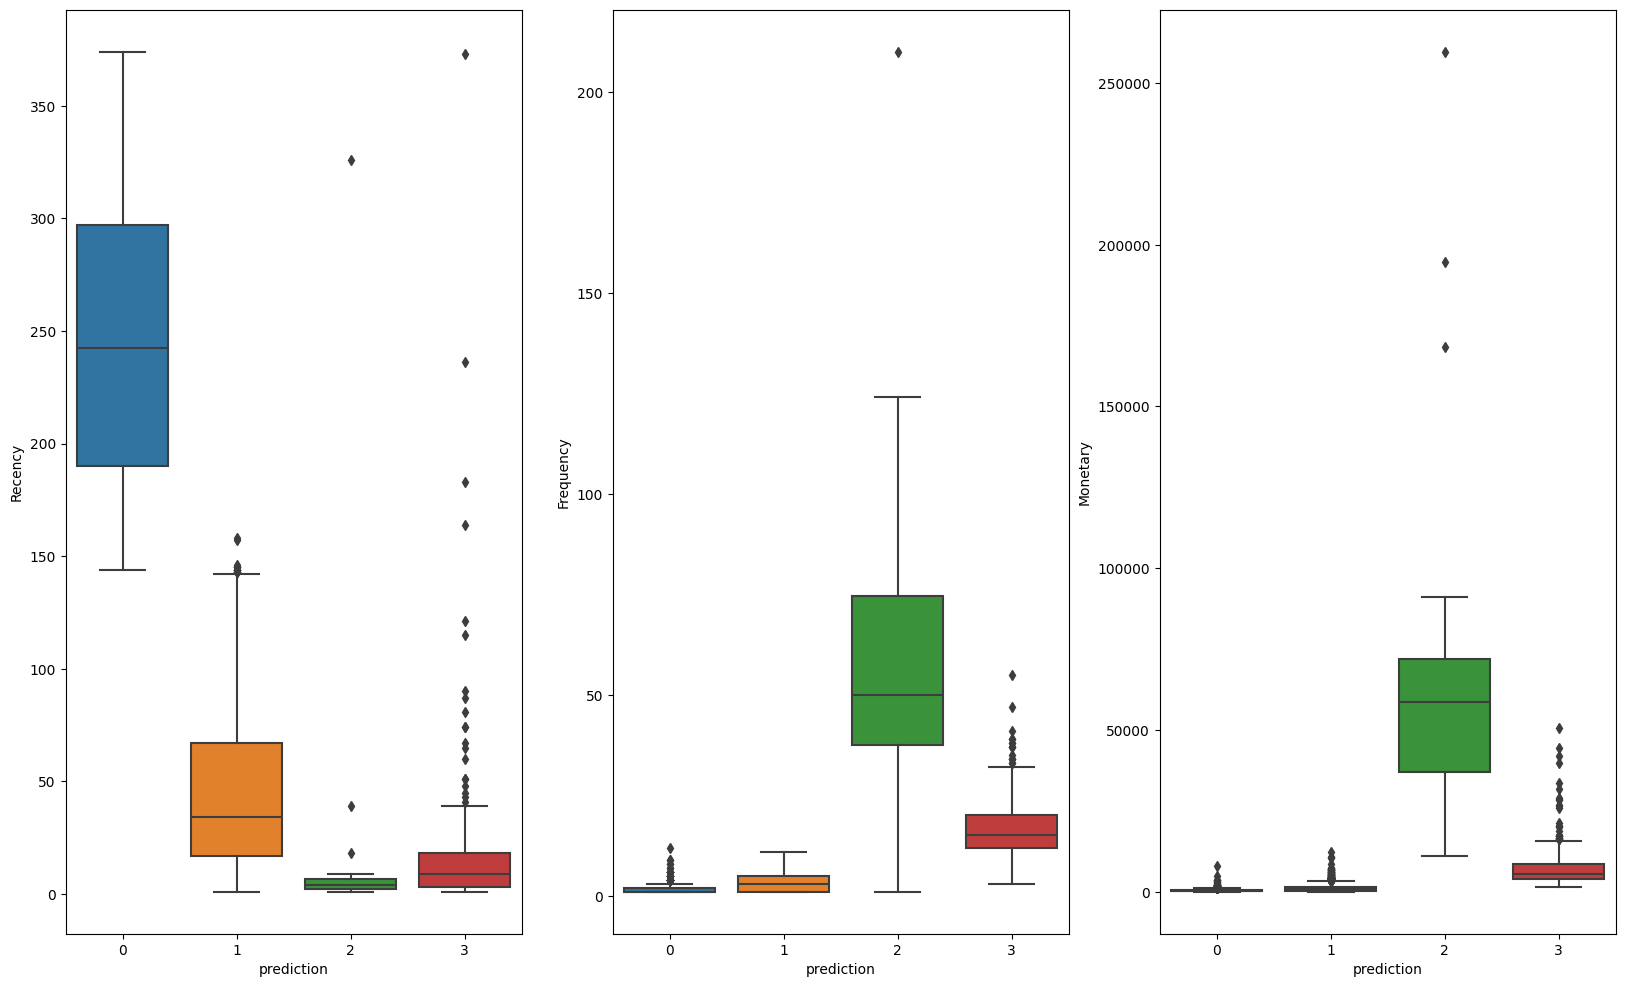

In [104]:
analysis_df = combined_result.toPandas()

fig, ax = plt.subplots(1, 3, figsize=(20, 12))
sns.boxplot(x='prediction', y='Recency', data=analysis_df, ax=ax[0])
sns.boxplot(x='prediction', y='Frequency', data=analysis_df, ax=ax[1])
sns.boxplot(x='prediction', y='Monetary', data=analysis_df, ax=ax[2])

# Visualization

<Axes: xlabel='Monetary', ylabel='Frequency'>

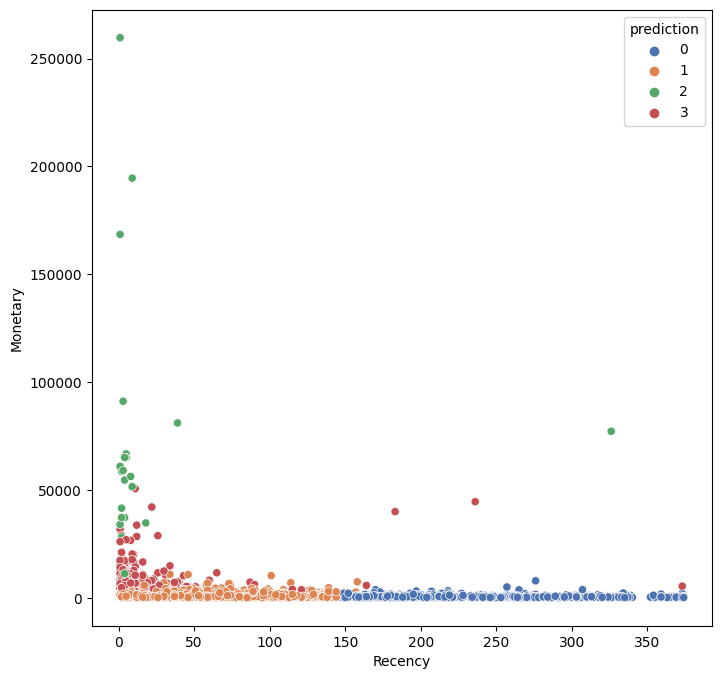

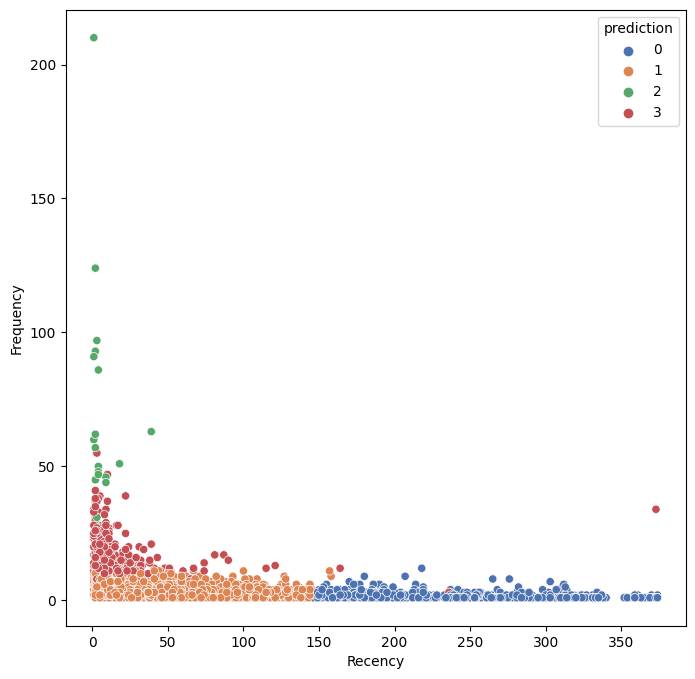

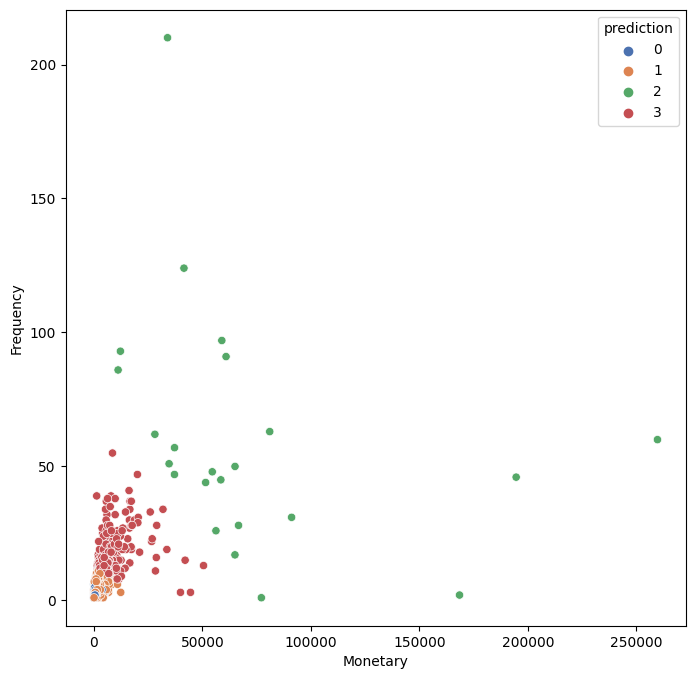

In [105]:
selected_result_df = combined_result_df#.query('Monetary < 100000').query('Frequency < 3000')

# Monetary vs Frequency (combined)
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
sns.scatterplot(x='Recency', y='Monetary', data=selected_result_df, hue='prediction', palette="deep")

# Monetary vs Frequency (combined)
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
sns.scatterplot(x='Recency', y='Frequency', data=selected_result_df, hue='prediction', palette="deep")

# Monetary vs Frequency (combined)
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
sns.scatterplot(x='Monetary', y='Frequency', data=selected_result_df, hue='prediction', palette="deep")

In [107]:
type(combined_result)

pyspark.sql.dataframe.DataFrame

In [110]:
analysis = combined_result\
    .groupBy('prediction')\
    .agg(F.avg('Recency').alias('Avg Recency'),
         F.avg('Frequency').alias('Avg Frequency'),
         F.avg('Monetary').alias('Avg Monetary'),
         F.count("*").alias("Count"),
        )
printdf(analysis)

,prediction,Avg Recency,Avg Frequency,Avg Monetary,Count
0,1,45.322629,3.327541,1144.536456,2647
1,3,17.044983,17.169550,7737.200692,289
2,2,19.782609,59.956522,71542.652174,23
3,0,247.623701,1.559252,440.398129,962
